# Quantile normalization with NumPy and SciPy

> Distress not yourself if you cannot at first understand the deeper mysteries
> of Spaceland. By degrees they will dawn upon you.
>
> — Edwin A. Abbott, *Flatland: A Romance of Many Dimensions*

In this chapter, we will continue to analyze the gene expression data from Chapter 1, but with a slightly different purpose: we want to use each patient's *gene expression profile* (the full vector of their gene expression measurements) to predict their expected survival.
In order to use full profiles, we need a stronger normalization than what Chapter 1's RPKM provides.
We will instead perform [*quantile normalization*](https://en.wikipedia.org/wiki/Quantile_normalization), a technique that ensures measurements fit a specific distribution.
This method enforces a strong assumption: if the data are not distributed according to a desired shape, we just make it fit!
This might feel a bit like cheating, but it turns out to be simple and useful in many cases where the specific distribution doesn't matter, but the relative changes of values within a population are important.
For example, Bolstad and colleagues [showed](https://doi.org/10.1093/bioinformatics/19.2.185) that it performs admirably in recovering known expression levels in microarray data.

Over the course of the chapter, we will reproduce a simplified version of [Figures 5A and 5B](http://www.cell.com/action/showImagesData?pii=S0092-8674%2815%2900634-0) from this [paper](http://dx.doi.org/10.1016/j.cell.2015.05.044), which comes from The Cancer Genome Atlas (TCGA) project.

Our implementation of quantile normalization uses NumPy and SciPy effectively to produce a function that is fast, efficient, and elegant. Quantile normalization involves three steps:
- sort the values along each column,
- find the average of each resulting row, and
- replace each column quantile with the quantile of the average column.

In [1]:
import numpy as np
from scipy import stats

def quantile_norm(X):
    """Normalize the columns of X to each have the same distribution.

    Given an expression matrix (microarray data, read counts, etc) of M genes
    by N samples, quantile normalization ensures all samples have the same
    spread of data (by construction).

    The data across each row are averaged to obtain an average column. Each
    column quantile is replaced with the corresponding quantile of the average
    column.

    Parameters
    ----------
    X : 2D array of float, shape (M, N)
        The input data, with M rows (genes/features) and N columns (samples).

    Returns
    -------
    Xn : 2D array of float, shape (M, N)
        The normalized data.
    """
    # compute the quantiles
    quantiles = np.mean(np.sort(X, axis=0), axis=1)

    # compute the column-wise ranks. Each observation is replaced with its
    # rank in that column: the smallest observation is replaced by 1, the
    # second-smallest by 2, ..., and the largest by M, the number of rows.
    ranks = np.apply_along_axis(stats.rankdata, 0, X)

    # convert ranks to integer indices from 0 to M-1
    rank_indices = ranks.astype(int) - 1

    # index the quantiles for each rank with the ranks matrix
    Xn = quantiles[rank_indices]

    return(Xn)

Due to the kind of variability of gene expression count data, it is common practice to log-transform the data before quantile-normalizing.
Thus, we write an additional helper function to transform to log:

In [2]:
def quantile_norm_log(X):
    logX = np.log(X + 1)
    logXn = quantile_norm(logX)
    return logXn

Together, these two functions illustrate many of the things that make NumPy powerful (you will remember the first three of these moves from chapter 1):

1. Arrays can be one-dimensional, like lists, but they can also be two-dimensional, like matrices, and higher-dimensional still. This allows them to represent many different kinds of numerical data. In our case, we are representing a 2D matrix.
2. Arrays allow the expression of many numerical operations at once. In the  first line of `quantile_norm_log`, we add one and take the logarithm for every value in `X` in a single call. This is called *vectorization*.
3. Arrays can be operated on along *axes*. In the first line of `quantile_norm`, we sort the data along each column just by specifying an `axis` parameter to `np.sort`. We then take the mean along each row by specifying a *different* `axis`.
4. Arrays underpin the scientific Python ecosystem. The `scipy.stats.rankdata` function operates not on Python lists, but on NumPy arrays. This is true of many scientific libraries in Python.
5. Even functions that don't have an `axis=` keyword can be made to operate along axes by NumPy's `apply_along_axis` function.
6. Arrays support many kinds of data manipulation through *fancy indexing*:
`Xn = quantiles[ranks]`. This is possibly the trickiest part of NumPy, but
also among the most useful. We will explore it further in the text that
follows.

## Getting the data

As in Chapter 1, we will be working with the The Cancer Genome Atlas (TCGA) skin cancer RNAseq data set.
Our goal is to predict mortality in skin cancer patients using their RNA expression data.
By the end of this chapter we will have reproduced a simplified version of [Figures 5A and 5B](http://www.cell.com/action/showImagesData?pii=S0092-8674%2815%2900634-0) of a [paper](http://dx.doi.org/10.1016/j.cell.2015.05.044) from the TCGA consortium.

As in Chapter 1, first we will use Pandas to make our job of reading in the data much easier.
First we will read in our counts data as a pandas table.

In [3]:
import numpy as np
import pandas as pd

# Import TCGA melanoma data
filename = 'data/counts.txt'
data_table = pd.read_csv(filename, index_col=0)  # Parse file with pandas

print(data_table.iloc[:5, :5])

       00624286-41dd-476f-a63b-d2a5f484bb45  TCGA-FS-A1Z0  TCGA-D9-A3Z1  \
A1BG                                1272.36        452.96        288.06   
A1CF                                   0.00          0.00          0.00   
A2BP1                                  0.00          0.00          0.00   
A2LD1                                164.38        552.43        201.83   
A2ML1                                 27.00          0.00          0.00   

       02c76d24-f1d2-4029-95b4-8be3bda8fdbe  TCGA-EB-A51B  
A1BG                                 400.11        420.46  
A1CF                                   1.00          0.00  
A2BP1                                  0.00          1.00  
A2LD1                                165.12         95.75  
A2ML1                                  0.00          8.00  


Looking at the rows and columns of `data_table`, we can see that the
columns are the samples, and the rows are the genes.
Now let's put our counts in a NumPy array.

In [4]:
# 2D ndarray containing expression counts for each gene in each individual
counts = data_table.values

## Gene expression distribution differences between individuals

Now, let's get a feel for our counts data by plotting the distribution of counts for each individual.
We will use a Gaussian kernel to smooth out bumps in our data so we can get a
better idea of the overall shape.

First, as usual, we set our plotting style:

In [5]:
# Make plots appear inline, set custom plotting style
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('style/elegant.mplstyle')

Next, we write a plotting function that makes use of SciPy's `gaussian_kde` function to plot smooth distributions:

In [6]:
from scipy import stats

def plot_col_density(data):
    """For each column, produce a density plot over all rows."""

    # Use Gaussian smoothing to estimate the density
    density_per_col = [stats.gaussian_kde(col) for col in data.T]
    x = np.linspace(np.min(data), np.max(data), 100)

    fig, ax = plt.subplots()
    for density in density_per_col:
        ax.plot(x, density(x))
    ax.set_xlabel('Data values (per column)')
    ax.set_ylabel('Density')

Now, we can use that function to plot the distributions of the raw data,
before we have done any normalization:

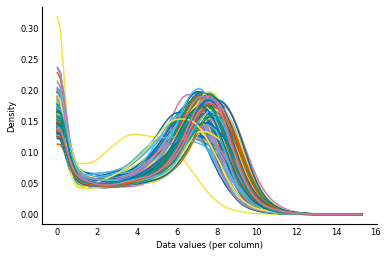

In [7]:
# Before normalization
log_counts = np.log(counts + 1)
plot_col_density(log_counts)

<!-- caption text="Density of gene expression counts for each individual (log scale)" -->

We can see that while the distributions of counts are broadly similar,
some individuals have flatter distributions and a few are pushed right over to the left.
In fact, realizing that this is a log scale, the location of the peak of the
distributions actually varies over an order of magnitude!
When doing our analysis of the counts data later in this chapter, we will be assuming
that changes in gene expression are due to biological differences between our samples.
But a major distribution shift like this suggests that the differences are technical.
That is, the changes are likely due to differences in the way we processed each sample,
rather than due to biological variation.
So we will try to normalize out these global differences between individuals.

To do this normalization, we will perform quantile normalization, as described
at the start of the chapter.  The idea is that all our samples should have a
similar distribution, so any differences in the shape should be due to some
technical variation.  More formally, given an expression matrix (microarray
data, read counts, etc) of shape `(n_genes, n_samples)`, quantile normalization
ensures that all samples (columns) have the same spread of data by construction.

With NumPy and SciPy, this can be done easily and efficiently.
To recap, here is our quantile normalization implementation, which we introduced at the beginning of the chapter.

Let's assume we've read in the input matrix as X:

In [8]:
import numpy as np
from scipy import stats

def quantile_norm(X):
    """Normalize the columns of X to each have the same distribution.

    Given an expression matrix (microarray data, read counts, etc) of M genes
    by N samples, quantile normalization ensures all samples have the same
    spread of data (by construction).

    The data across each row are averaged to obtain an average column. Each
    column quantile is replaced with the corresponding quantile of the average
    column.

    Parameters
    ----------
    X : 2D array of float, shape (M, N)
        The input data, with M rows (genes/features) and N columns (samples).

    Returns
    -------
    Xn : 2D array of float, shape (M, N)
        The normalized data.
    """
    # compute the quantiles
    quantiles = np.mean(np.sort(X, axis=0), axis=1)

    # compute the column-wise ranks. Each observation is replaced with its
    # rank in that column: the smallest observation is replaced by 1, the
    # second-smallest by 2, ..., and the largest by M, the number of rows.
    ranks = np.apply_along_axis(stats.rankdata, 0, X)

    # convert ranks to integer indices from 0 to M-1
    rank_indices = ranks.astype(int) - 1

    # index the quantiles for each rank with the ranks matrix
    Xn = quantiles[rank_indices]

    return(Xn)


def quantile_norm_log(X):
    logX = np.log(X + 1)
    logXn = quantile_norm(logX)
    return logXn

Now, let's see what our distributions look like after quantile normalization.

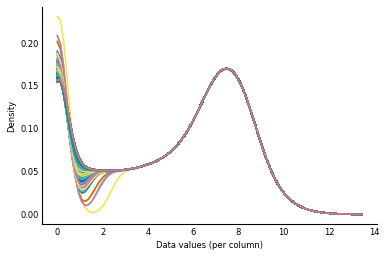

In [9]:
# After normalization
log_counts_normalized = quantile_norm_log(counts)

plot_col_density(log_counts_normalized)

<!-- caption text="Density of gene expression counts for each individual after quantile normalization (log scale)" -->

As you might expect, the distributions now look virtually identical!
(The different left tails of the distribution have to do with different
numbers of ties for low count values — 0, 1, 2, ... — in the different
columns of the data.)

Now that we have normalized our counts, we can start using our gene expression data to predict patient prognosis.

## Biclustering the counts data


Clustering the samples tells us which samples have similar gene expression profiles, which may indicate similar characteristics of the samples on other scales.
Now that the data are normalized, we can cluster the genes (rows) and samples (columns) of the expression matrix.
Clustering the rows tells us which genes' expression values are linked, which is an indication that they work together in the process being studied.
*Biclustering* means that we are simultaneously clustering both the rows and columns of our data.
By clustering along the rows we find out with genes are working together, and by clustering along the columns we find out which samples are similar.

Because clustering can be an expensive operation, we will limit our analysis to the 1,500 genes that are most variable, since these will account for most of the correlation signal in either dimension.

In [10]:
def most_variable_rows(data, *, n=1500):
    """Subset data to the n most variable rows

    In this case, we want the n most variable genes.

    Parameters
    ----------
    data : 2D array of float
        The data to be subset
    n : int, optional
        Number of rows to return.

    Returns
    -------
    variable_data : 2D array of float
        The `n` rows of `data` that exhibit the most variance.
    """
    # compute variance along the columns axis
    rowvar = np.var(data, axis=1)
    # Get sorted indices (ascending order), take the last n
    sort_indices = np.argsort(rowvar)[-n:]
    # use as index for data
    variable_data = data[sort_indices, :]
    return variable_data

Next, we need a function to bicluster the data.
Normally, you would use a sophisticated clustering algorithm from the [scikit-learn](http://scikit-learn.org) library for this.
In our case, we want to use hierarchical clustering for simplicity and ease of display.
The SciPy library happens to have a perfectly good hierarchical clustering module, though it requires a bit of wrangling to get your head around its interface.

As a reminder, hierarchical clustering is a method to group observations using sequential merging of clusters:
initially, every observation is its own cluster.
Then, the two nearest clusters are repeatedly merged, and then the next two,
and so on, until every observation is in a single cluster.
This sequence of merges forms a *merge tree*.
By cutting the tree at a specific height, we can get a finer or coarser clustering of observations.

The `linkage` function in `scipy.cluster.hierarchy` performs a hierarchical clustering of the rows of a matrix, using a particular metric (for example, Euclidean distance, Manhattan distance, or others) and a particular linkage method, the distance between two clusters (for example, the average distance between all the observations in a pair of clusters).

It returns the merge tree as a "linkage matrix", which contains each merge operation along with the distance computed for the merge and the number of observations in the resulting cluster. From the `linkage` documentation:

> A cluster with an index less than $n$ corresponds to one of
> the $n$ original observations. The distance between
> clusters `Z[i, 0]` and `Z[i, 1]` is given by `Z[i, 2]`. The
> fourth value `Z[i, 3]` represents the number of original
> observations in the newly formed cluster.

Whew! That's a lot of information, but let's dive right in and hopefully you'll get the hang of it rather quickly.
First, we define a function, `bicluster`, that clusters both the rows *and* the columns of a matrix:

In [11]:
from scipy.cluster.hierarchy import linkage


def bicluster(data, linkage_method='average', distance_metric='correlation'):
    """Cluster the rows and the columns of a matrix.

    Parameters
    ----------
    data : 2D ndarray
        The input data to bicluster.
    linkage_method : string, optional
        Method to be passed to `linkage`.
    distance_metric : string, optional
        Distance metric to use for clustering. See the documentation
        for ``scipy.spatial.distance.pdist`` for valid metrics.

    Returns
    -------
    y_rows : linkage matrix
        The clustering of the rows of the input data.
    y_cols : linkage matrix
        The clustering of the cols of the input data.
    """
    y_rows = linkage(data, method=linkage_method, metric=distance_metric)
    y_cols = linkage(data.T, method=linkage_method, metric=distance_metric)
    return y_rows, y_cols

Simple: we just call `linkage` for the input matrix and also for the *transpose* of that matrix, in which columns become rows and rows become columns.

## Visualizing clusters

Next, we define a function to visualize the output of that clustering.
We are going to rearrange the rows and columns of the input data so that similar rows are together and similar columns are together.
And we are additionally going to show the merge tree for both rows and columns, displaying which observations belong together for each.
The merge trees are presented as dendrograms, with the branch-lengths indicating how similar the observations are to each other (shorter = more similar).

As a word of warning, there is a fair bit of hard-coding of parameters going on here.
This is difficult to avoid for plotting, where design is often a matter of eyeballing to find the correct proportions.

In [12]:
from scipy.cluster.hierarchy import dendrogram, leaves_list


def clear_spines(axes):
    for loc in ['left', 'right', 'top', 'bottom']:
        axes.spines[loc].set_visible(False)
    axes.set_xticks([])
    axes.set_yticks([])


def plot_bicluster(data, row_linkage, col_linkage,
                   row_nclusters=10, col_nclusters=3):
    """Perform a biclustering, plot a heatmap with dendrograms on each axis.

    Parameters
    ----------
    data : array of float, shape (M, N)
        The input data to bicluster.
    row_linkage : array, shape (M-1, 4)
        The linkage matrix for the rows of `data`.
    col_linkage : array, shape (N-1, 4)
        The linkage matrix for the columns of `data`.
    n_clusters_r, n_clusters_c : int, optional
        Number of clusters for rows and columns.
    """
    fig = plt.figure(figsize=(4.8, 4.8))

    # Compute and plot row-wise dendrogram
    # `add_axes` takes a "rectangle" input to add a subplot to a figure.
    # The figure is considered to have side-length 1 on each side, and its
    # bottom-left corner is at (0, 0).
    # The measurements passed to `add_axes` are the left, bottom, width, and
    # height of the subplot. Thus, to draw the left dendrogram (for the rows),
    # we create a rectangle whose bottom-left corner is at (0.09, 0.1), and
    # measuring 0.2 in width and 0.6 in height.
    ax1 = fig.add_axes([0.09, 0.1, 0.2, 0.6])
    # For a given number of clusters, we can obtain a cut of the linkage
    # tree by looking at the corresponding distance annotation in the linkage
    # matrix.
    threshold_r = (row_linkage[-row_nclusters, 2] +
                   row_linkage[-row_nclusters+1, 2]) / 2
    with plt.rc_context({'lines.linewidth': 0.75}):
        dendrogram(row_linkage, orientation='left',
                   color_threshold=threshold_r, ax=ax1)
    clear_spines(ax1)

    # Compute and plot column-wise dendrogram
    # See notes above for explanation of parameters to `add_axes`
    ax2 = fig.add_axes([0.3, 0.71, 0.6, 0.2])
    threshold_c = (col_linkage[-col_nclusters, 2] +
                   col_linkage[-col_nclusters+1, 2]) / 2
    with plt.rc_context({'lines.linewidth': 0.75}):
        dendrogram(col_linkage, color_threshold=threshold_c, ax=ax2)
    clear_spines(ax2)

    # Plot data heatmap
    ax = fig.add_axes([0.3, 0.1, 0.6, 0.6])

    # Sort data by the dendrogram leaves
    idx_rows = leaves_list(row_linkage)
    data = data[idx_rows, :]
    idx_cols = leaves_list(col_linkage)
    data = data[:, idx_cols]

    im = ax.imshow(data, aspect='auto', origin='lower', cmap='YlGnBu_r')
    clear_spines(ax)

    # Axis labels
    ax.set_xlabel('Samples')
    ax.set_ylabel('Genes', labelpad=125)

    # Plot legend
    axcolor = fig.add_axes([0.91, 0.1, 0.02, 0.6])
    plt.colorbar(im, cax=axcolor)

    # display the plot
    plt.show()

Now we apply these functions to our normalized counts matrix to display row and column clusterings.

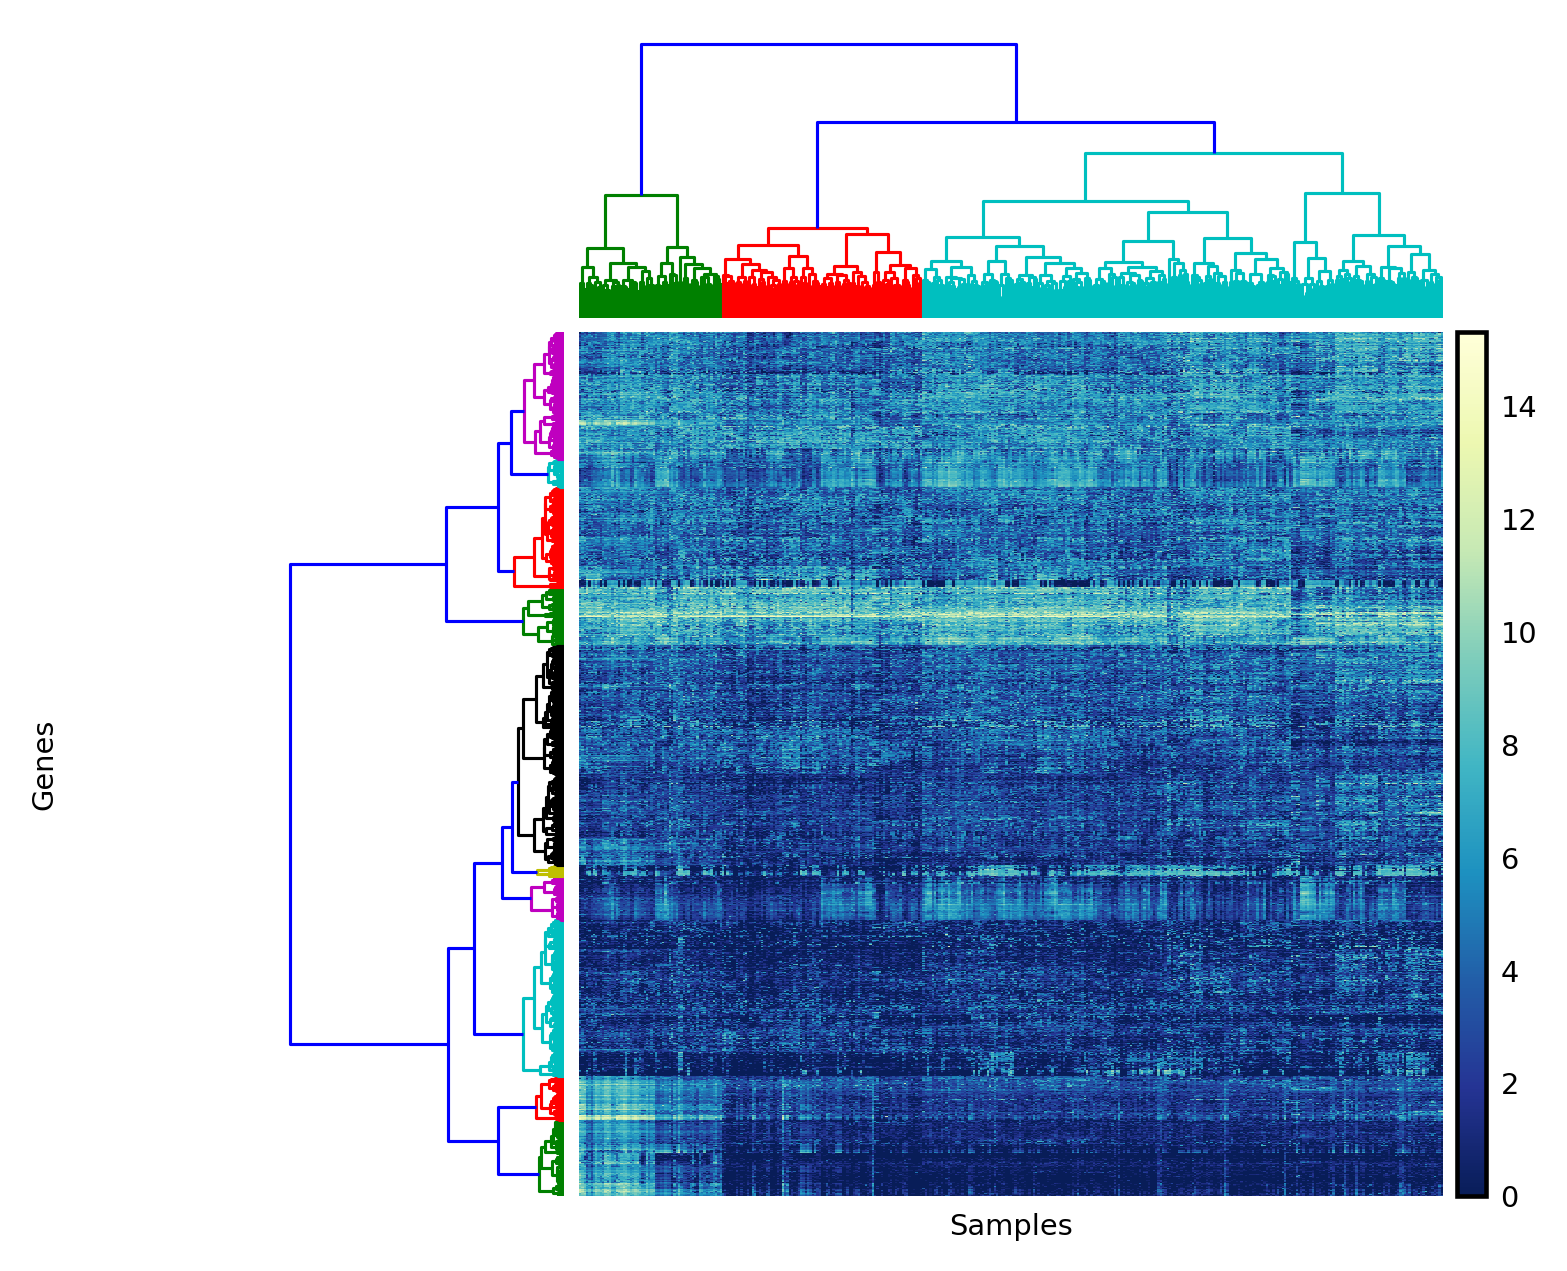

In [13]:
counts_log = np.log(counts + 1)
counts_var = most_variable_rows(counts_log, n=1500)
yr, yc = bicluster(counts_var, linkage_method='ward',
                   distance_metric='euclidean')
with plt.style.context('style/thinner.mplstyle'):
    plot_bicluster(counts_var, yr, yc)

<!-- caption text="This heatmap shows the level of gene expression across all samples and genes. The color indicates the expression level. The rows and columns are grouped by our clusters. We can see our gene clusters along the y-axis and sample clusters across the top of the x-axis." -->

## Predicting survival

We can see that the sample data naturally falls into at least 2 clusters, maybe 3.
Are these clusters meaningful?
To answer this, we can access the patient data, available from the [data repository](https://tcga-data.nci.nih.gov/docs/publications/skcm_2015/) for the paper.
After some preprocessing, we get the [patients table](https://github.com/elegant-scipy/elegant-scipy/blob/master/data/patients.csv), which contains survival information for each patient.
We can then match these to the counts clusters, and understand whether the patients' gene expression can predict differences in their pathology.

In [14]:
patients = pd.read_csv('data/patients.csv', index_col=0)
patients.head()

,UV-signature,original-clusters,melanoma-survival-time,melanoma-dead
TCGA-BF-A1PU,UV signature,keratin,NaN,NaN
TCGA-BF-A1PV,UV signature,keratin,13.0,0.0
TCGA-BF-A1PX,UV signature,keratin,NaN,NaN
TCGA-BF-A1PZ,UV signature,keratin,NaN,NaN
TCGA-BF-A1Q0,not UV,immune,17.0,0.0


For each patient (the rows) we have:

- UV­ signature: Ultraviolet light tends to cause specific DNA mutations.
By looking for this mutation signature researchers can infer whether UV light likely caused the mutation(s) that lead to cancer in these patients.
- original­ clusters: In the paper, the patients were clustered using gene expression data.
These clusters were classified according to the types of genes that typified that cluster.
The main clusters were "immune" (n = 168; 51%), "keratin" (n = 102; 31%), and "MITF-low" (n = 59; 18%).
- melanoma­ survival­ time: Number of days that the patient survived.
- melanoma­ dead: 1 if the patient died of melanoma, 0 if they are alive or died of something else.

Now we need to draw *survival curves* for each group of patients defined by the clustering.
This is a plot of the fraction of a population that remains alive over a period of time.
Note that some data is *right-censored*, which means that in some cases, we don't actually know when the patient died, or the patient might have died of causes unrelated to the melanoma.
We count these patients as "alive" for the duration of the survival curve, but more sophisticated analyses might try to estimate their likely time of death.

To obtain a survival curve from survival times, we create a step function that decreases by $1/n$ at each step, where $n$ is the number of patients in the group.
We then match that function against the non-censored survival times.

In [15]:
def survival_distribution_function(lifetimes, right_censored=None):
    """Return the survival distribution function of a set of lifetimes.

    Parameters
    ----------
    lifetimes : array of float or int
        The observed lifetimes of a population. These must be non-
        -negative.
    right_censored : array of bool, same shape as `lifetimes`
        A value of `True` here indicates that this lifetime was not
        observed. Values of `np.nan` in `lifetimes` are also considered
        to be right-censored.

    Returns
    -------
    sorted_lifetimes : array of float
        The
    sdf : array of float
        Values starting at 1 and progressively decreasing, one level
        for each observation in `lifetimes`.

    Examples
    --------

    In this example, of a population of four, two die at time 1, a
    third dies at time 2, and a final individual dies at an unknown
    time. (Hence, ``np.nan``.)

    >>> lifetimes = np.array([2, 1, 1, np.nan])
    >>> survival_distribution_function(lifetimes)
    (array([ 0.,  1.,  1.,  2.]), array([ 1.  ,  0.75,  0.5 ,  0.25]))
    """
    n_obs = len(lifetimes)
    rc = np.isnan(lifetimes)
    if right_censored is not None:
        rc |= right_censored
    observed = lifetimes[~rc]
    xs = np.concatenate( ([0], np.sort(observed)) )
    ys = np.linspace(1, 0, n_obs + 1)
    ys = ys[:len(xs)]
    return xs, ys

Now that we can easily obtain survival curves from the survival data, we can plot them.
We write a function that groups the survival times by cluster identity and plots each group as a different line:

In [16]:
def plot_cluster_survival_curves(clusters, sample_names, patients,
                                 censor=True):
    """Plot the survival data from a set of sample clusters.

    Parameters
    ----------
    clusters : array of int or categorical pd.Series
        The cluster identity of each sample, encoded as a simple int
        or as a pandas categorical variable.
    sample_names : list of string
        The name corresponding to each sample. Must be the same length
        as `clusters`.
    patients : pandas.DataFrame
        The DataFrame containing survival information for each patient.
        The indices of this DataFrame must correspond to the
        `sample_names`. Samples not represented in this list will be
        ignored.
    censor : bool, optional
        If `True`, use `patients['melanoma-dead']` to right-censor the
        survival data.
    """
    fig, ax = plt.subplots()
    if type(clusters) == np.ndarray:
        cluster_ids = np.unique(clusters)
        cluster_names = ['cluster {}'.format(i) for i in cluster_ids]
    elif type(clusters) == pd.Series:
        cluster_ids = clusters.cat.categories
        cluster_names = list(cluster_ids)
    n_clusters = len(cluster_ids)
    for c in cluster_ids:
        clust_samples = np.flatnonzero(clusters == c)
        # discard patients not present in survival data
        clust_samples = [sample_names[i] for i in clust_samples
                         if sample_names[i] in patients.index]
        patient_cluster = patients.loc[clust_samples]
        survival_times = patient_cluster['melanoma-survival-time'].values
        if censor:
            censored = ~patient_cluster['melanoma-dead'].values.astype(bool)
        else:
            censored = None
        stimes, sfracs = survival_distribution_function(survival_times,
                                                        censored)
        ax.plot(stimes / 365, sfracs)

    ax.set_xlabel('survival time (years)')
    ax.set_ylabel('fraction alive')
    ax.legend(cluster_names)

Now we can use the `fcluster` function to obtain cluster identities for the samples (columns of the counts data), and plot each survival curve separately.
The `fcluster` function takes a linkage matrix, as returned by `linkage`, and a threshold, and returns cluster identities.
It's difficult to know a-priori what the threshold should be, but we can obtain the appropriate threshold for a fixed number of clusters by checking the distances in the linkage matrix.

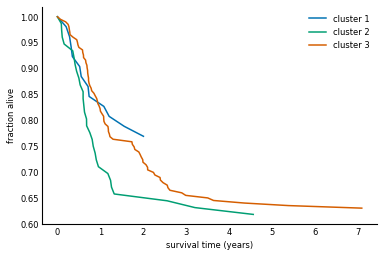

In [17]:
from scipy.cluster.hierarchy import fcluster
n_clusters = 3
threshold_distance = (yc[-n_clusters, 2] + yc[-n_clusters+1, 2]) / 2
clusters = fcluster(yc, threshold_distance, 'distance')

plot_cluster_survival_curves(clusters, data_table.columns, patients)

<!-- caption text="Survival curves for patients clustered using gene expression data" -->

The clustering of gene expression profiles appears to have identified a
higher-risk subtype of melanoma (cluster 2).
The TCGA study backs this claim up with a more robust clustering and
statistical testing. This is indeed only the latest study to show such a
result, with others identifying subtypes of leukemia (blood cancer), gut
cancer, and more. Although the above clustering technique is quite fragile,
there are other, more robust ways to explore this and similar datasets [^paper].

<!-- exercise begin -->

**Exercise:** Do our clusters do a better job of predicting survival than the original clusters in the paper? What about UV signature?

Plot survival curves using the original clusters and UV signature columns of the patient data. How do they compare to our clusters?
<!-- exercise end -->

<!-- exercise begin -->

**Exercise:** We leave you the exercise of implementing the approach described in the paper[^paper]:

1. Take bootstrap samples (random choice with replacement) of the genes used to cluster the samples;
2. For each sample, produce a hierarchical clustering;
3. In a `(n_samples, n_samples)`-shaped matrix, store the number of times a sample pair appears together in a bootstrapped clustering.
4. Perform a hierarchical clustering on the resulting matrix.

This identifies groups of samples that frequently occur together in clusterings, regardless of the genes chosen.
Thus, these samples can be considered to robustly cluster together.

*Hint: use `np.random.choice` with `replacement=True` to create bootstrap samples of row indices.*

<!-- exercise end -->

[^paper]: The Cancer Genome Atlas Network. (2015) Genomic Classification of
          Cutaneous Melanoma. Cell 161:1681-1696.
          http://dx.doi.org/10.1016/j.cell.2015.05.044